In [2]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
import random

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

#Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### 1. Load the data

In [3]:
t1 = time.time()

data_type = 'N1'

for data_type in ['N1']:
    channels = constants.channel_list
    
    # 1. generate all path names and class list(s) etc. 
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
    paths = joblib.load(folder + data_type + '_paths.pkl') # keys : ['selected_paths', 's_class_list', 's_night_list', 's_sleep_type', 's_p_id']
    
    # 2. Load corresponding data into dataframes, store in dataframe list
    df_list = []
    
    with io.capture_output() as captured:
        for path in paths['selected_paths']:
            data_epo = mne.read_epochs(path)
            data = data_epo._data * 1e6  # convert signal from V to uV
            df_full = data_epo.to_data_frame()
            df = df_full[channels].copy()
            df_list.append(df)


t2 = time.time()

t2-t1

31.468985080718994

In [4]:
class_label_dict = {'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3} #Dictionary used to label the classes for reference
y = np.array([class_label_dict[c_name] for c_name in paths['s_class_list'] ] )
groups = paths['s_p_id']

In [5]:
wake_dfs_binary = []
y_binary = []
groups_binary = []

for df , class_label , group in zip(df_list, y, groups):
    if class_label in [0,1]:
        wake_dfs_binary.append(df)
        y_binary.append(class_label)
        groups_binary.append(group)

y_binary = np.array(y_binary)

In [6]:
#Minimum sample length is 1 minute but the mean is ~ 3 minutes

#### 2. Generate the spectrograms (Prefrontal)

In [7]:
regions = constants.regions
region_channel_dict = constants.region_to_channel_dict
channel_list = constants.channel_list
region_channel_dict['Prefrontal']

['Fp1', 'Fpz', 'Fp2']

In [94]:
#For each dataframe generate a spectrogram
regional_spectrograms = []

for df in wake_dfs_binary:
    
    channel_spectrograms = []
    for channel in region_channel_dict['Prefrontal']:
        
        #for each channel generate a spectrogram, then take the mean of the spectrograms to get the regional spectrogram
           
        eeg_data = df[channel].values 

        # g_std is standard deviation for Gaussian window in samples
        g_std = 200
        w = gaussian(g_std*2, std=g_std, sym=True)  # symmetric Gaussian window of total width 50 samples
        mfft = max(256 , g_std*2)
        
        #Perform STFT 
        SFT = ShortTimeFFT(w, hop=100, fs=256, mfft=mfft, scale_to='magnitude')   
        Sx = SFT.stft(eeg_data)  
        Sx_abs = abs(Sx)
        
        #I can obtain the corresponding frequency values for this spectrogram with 
        frequency_vals = SFT.f
        
        # I want to snip the frequency values to the range I'm interested in 0-40 Hz
        def find_first_above(array, threshold):
            for index, value in enumerate(array):
                if value > threshold:
                    return index
            return -1  # Return -1 if no such value is found
        
        ind = find_first_above(frequency_vals, 40)
        
        frequency_vals = frequency_vals[:ind+1]
        
        #To update the time values I need to input the number of vals in the original sequency 
        num_seq_vals = len(eeg_data)
        time_vals = SFT.t(num_seq_vals)
        
        # snip the spectrogram array to values that are of interest 
        Sx_abs = Sx_abs[:ind+1 , :]

        #Generate the power from the magnitude
        Sx_db = 10*np.log10( np.square(Sx_abs))
        
        channel_spectrograms.append(Sx_db)
        # [Sx_db , time_vals , frequency_vals]
    
    stacked_arrays = np.stack( channel_spectrograms)
    mean_spectrogram = np.mean(stacked_arrays, axis = 0)
    regional_spectrograms.append(mean_spectrogram)

In [93]:
time_vals[80]

30.859375

#### 3. Generate 1 minute spectrogram slices 

(array([705.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 913.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

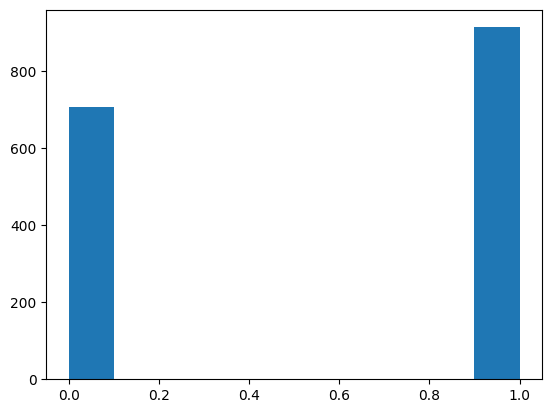

In [95]:
# Generate 30 second slices
# The 157 for 1 minute is derived from the time_vals axis in the spectrogram
segment_length = 110
overlap = 0.5 

spectrogram_slices = []
y_slice_labels = []
y_slice_groups = []

for spectrogram, label, group in zip(regional_spectrograms, y_binary, groups_binary):
    
    num_segments = int( np.floor(spectrogram.shape[1]/segment_length) )
    new_specs = []
    
    for i in np.arange(0,num_segments, 1 - overlap):
        if i > num_segments - 1 :
            # if signal is 4 full minutes, I don't want it to try and take a window from 3.5 minutes to 4.5 minutes
            # will be an incomplete slice causing errors downstream, needs to stop 
            break
          
        start_index = int( np.floor(i*segment_length) )
        end_index = start_index + segment_length
        new_spec = spectrogram[: , start_index : end_index]
        
        spectrogram_slices.append(new_spec)
        y_slice_labels.append(label)
        y_slice_groups.append(group)
        
plt.hist(np.array(y_slice_labels) )

(array([76.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 52.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

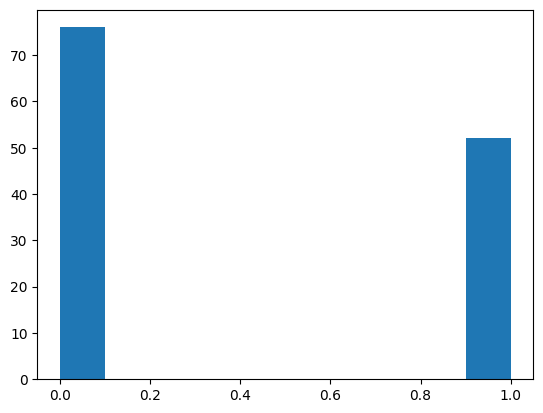

In [70]:
# The 157 for 1 minute is derived from the time_vals axis in the spectrogram
overlap = 0.5 

spectrogram_slices = []
y_slice_labels = []
y_slice_groups = []

for spectrogram, label, group in zip(regional_spectrograms, y_binary, groups_binary):
    
    num_segments = int( np.floor(spectrogram.shape[1]/157) )
    new_specs = []
    
    for i in np.arange(0,num_segments, 1 - overlap):
        if i > num_segments - 1 :
            # if signal is 4 full minutes, I don't want it to try and take a window from 3.5 minutes to 4.5 minutes
            # will be an incomplete slice causing errors downstream, needs to stop 
            break
          
        start_index = int( np.floor(i*157) )
        end_index = start_index + 157
        new_spec = spectrogram[: , start_index : end_index]
        
        spectrogram_slices.append(new_spec)
        y_slice_labels.append(label)
        y_slice_groups.append(group)
        
plt.hist(np.array(y_slice_labels) )

#### 4. Create the CNN

In [33]:
#I want to dynamically change the shape of the CNN according to the size of the input 
spectrogram_slices[0].shape

(64, 110)

In [12]:
# Conv layer
# 64 x 157 ---> 61 x 154
# Max Pool 
# 16 channels ---> 61 / 4 , 154 / 4 ..... 15.25 x 38.5 ... 15 x 38
# Conv layer 15 x 38 ---> 12 x 35 
# Max Pool 15 x 38 ---> 3 x 8 

In [96]:
def out_dim(x):
    '''
    Function to calculate output dimensions for neural network to make it easy for me to define NN for changing window sizes. 
    Action on width and height dim sizes are currently equivalent
    '''
    x = x-3 #convolutional filter of size 4 applied 
    x = int( np.floor(x/4) ) # effect of maxpooling 4 x 4 
    x = x-3 #convolutional filter of size 4 applied
    x = int( np.floor(x/4) ) # effect of maxpooling 4 x 4 
    return x
    
out_dim(157)

8

In [97]:
class AdaptiveConvolutionalNetwork(nn.Module):
    def __init__(self, input_width = 110 , input_height = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,4,1)
        self.conv2 = nn.Conv2d(6, 16, 4, 1)

        self.out_h = out_dim(input_height) 
        self.out_w = out_dim(input_width)
        
        self.fc1 = nn.Linear(16*self.out_h*self.out_w, int(np.floor( 16*self.out_h*self.out_w / 2) ))
        self.fc2 = nn.Linear(int(np.floor( 16*self.out_h*self.out_w / 2) ), 50)
        self.fc3 = nn.Linear(50,1)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,4,4)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,4,4)
        
        X = X.view(-1, 16*self.out_h*self.out_w)
        
        X = F.relu(self.fc1(X) )
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        # return F.log_softmax(X, dim=1 )
        return X

In [22]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,4,1)
        self.conv2 = nn.Conv2d(6, 16, 4, 1)
        
        self.fc1 = nn.Linear(16*3*8, 200)
        self.fc2 = nn.Linear(200, 60)
        self.fc3 = nn.Linear(60,1)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,4,4)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,4,4)
        
        X = X.view(-1, 16*3*8)
        
        X = F.relu(self.fc1(X) )
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        # return F.log_softmax(X, dim=1 )
        return X

#### 5. Fit the model

##### Trialling splits of the data according to group (participant id)

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

In [99]:
np.unique(groups_train)

array([1102, 1103, 1104, 1105, 1108, 1109, 1110, 1111, 1112, 1113, 1116,
       1118, 4403, 4404, 4406, 4407, 4409, 4410])

In [100]:
# Function to check the condition
def check_numbers(arr):
    arr = np.unique(arr)
    count_1s = sum(str(num).startswith('1') for num in arr)
    count_4s = sum(str(num).startswith('4') for num in arr)
    
    return count_1s >= 2 and count_4s >= 2

In [101]:
# Function to check the condition
check_numbers(groups_train)

True

In [102]:
# Function to check the condition

groups

array([1101, 1101, 1101, ..., 4411, 4411, 4411])

In [103]:
# spectrogram_slices, y_slice_labels and y_slice_groups to work with
train_val_test_dict = {}

for value in ['train' , 'val', 'test']:
    train_val_test_dict[value] = {}

X = np.stack(spectrogram_slices)
y = np.array(y_slice_labels)
groups = np.array( [int(group) for group in y_slice_groups] )

gkf = GroupKFold(n_splits = 5) 
fold = 0

for full_train_index, test_index  in gkf.split(X, y, groups*-1):
    fold += 1
    
    X_full_train, y_full_train, groups_full_train = X[full_train_index], y[full_train_index] , groups[full_train_index]
    X_test, y_test, groups_test =   X[test_index], y[test_index] , groups[test_index]
    
    gkf_inner = GroupKFold(n_splits = 4) 
    for train_index, val_index  in gkf_inner.split(X_full_train, y_full_train, groups_full_train):
        X_train, y_train, groups_train = X_full_train[train_index], y_full_train[train_index] , groups_full_train[train_index]
        X_val, y_val, groups_val =  X_full_train[val_index], y_full_train[val_index] , groups_full_train[val_index]

         
        train_val_test_dict['train'][fold] = X_train, y_train, groups_train
        train_val_test_dict['val'][fold]   = X_val, y_val, groups_val
        break
        

    
    train_val_test_dict['test'][fold]  = X_test, y_test, groups_test
    
    total_len = len(X) 
    val_percent = 100*(len(X_val) / total_len)
    train_percent = 100*(len(X_train) / total_len)
    test_percent = 100*(len(X_test) / total_len)
    print('fold ' + str(fold) ) 
    print( str(train_percent)[:3] + ' | '  + str(val_percent)[:3] + ' | ' + str(test_percent)[:3] + ' | ' )

    # testing that the splits are as expected
    print( np.unique(groups_train) )
    print( np.unique(groups_val) )
    print( np.unique(groups_test) ) 
    
    print('__________________________________________________________________________')

#Output from this section of code is X_train, y_train, groups_train AND X_test, y_test, groups_test 

fold 1
60. | 19. | 20. | 
[1102 1103 1104 1105 1108 1109 1110 1111 1112 1113 1116 1118 4403 4404
 4406 4407 4409 4410]
[1101 1106 4405 4408 4411]
[1117 1119 4401 4402]
__________________________________________________________________________
fold 2
60. | 20. | 19. | 
[1102 1103 1104 1105 1108 1109 1110 1111 1112 1113 1116 1117 4403 4404
 4406 4407 4409 4410]
[1118 1119 4401 4402]
[1101 1106 4405 4408 4411]
__________________________________________________________________________
fold 3
59. | 20. | 20. | 
[1101 1103 1106 1108 1109 1110 1111 1113 1116 1118 4405 4406 4407 4408
 4409 4410 4411]
[1117 1119 4401 4402]
[1102 1104 1105 1112 4403 4404]
__________________________________________________________________________
fold 4
59. | 20. | 20. | 
[1101 1102 1105 1106 1108 1109 1110 1111 1112 1113 1116 4402 4403 4404
 4405 4408 4411]
[1104 1117 1119 4401]
[1103 1118 4406 4407 4409 4410]
__________________________________________________________________________
fold 5
59. | 20. | 20. | 
[1

##### Creating data loader

In [104]:
#Choose which fold _______________________
# It is problematic that y_val here is also named in the below training code as y_val
fold = 1
X_train, y_train, groups_train = train_val_test_dict['train'][fold]
X_val, y_val, groups_val = train_val_test_dict['val'][fold] 
X_test, y_test, groups_test = train_val_test_dict['test'][fold]  

# Creating train and test data loaders
input_width = 110
train_data = [ (torch.from_numpy(spectrogram).float().view(1,64,input_width), val) for spectrogram, val in zip(X_train, y_train) ] 
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)

val_data = [ (torch.from_numpy(spectrogram).float().view(1,64,input_width), val) for spectrogram, val in zip(X_val, y_val) ] 
val_loader = DataLoader(val_data , batch_size=5, shuffle=False)

test_data = [ (torch.from_numpy(spectrogram).float().view(1,64,input_width), val) for spectrogram, val in zip(X_test, y_test) ] 
test_loader = DataLoader(test_data , batch_size=5, shuffle=False)

torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-40GB'

##### Fit the model

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ConvolutionalNetwork()
model = AdaptiveConvolutionalNetwork(input_width = input_width)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )

cuda


In [106]:
import time

start_time = time.time()

epochs = 100
train_losses = []
val_losses = []
test_losses = []

train_correct = []
val_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    val_corr = 0
    tst_corr = 0
     
    
    trn_loss = 0
    val_loss = 0
    tst_loss = 0
    
    # Run the training batches
    for b, (X_train_batch, y_train_batch) in enumerate(train_loader):
        b+=1

        #Move train data to the GPU
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)
        
        # Apply the model
        y_pred = model(X_train_batch)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train_batch.unsqueeze(1).float())
 
        # Tally the number of correct predictions
        predicted = torch.round(F.sigmoid(y_pred.detach() ) )
        predicted = predicted.reshape(y_train_batch.shape)
        
        batch_corr = (predicted == y_train_batch).sum()
        trn_corr += batch_corr
        trn_loss += loss
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(trn_loss)
    train_correct.append(trn_corr)

    # Run the validation batches
    # Some of the variables in this loop have the same name as the variables in the above loop... be aware of that plz!
    with torch.no_grad():
        for b, (X_val_batch, y_val_batch) in enumerate(val_loader):
            b+=1
            
            #Move train data to the GPU
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            # Apply the model
            y_val = model(X_val_batch)

            # Tally the number of correct predictions
            predicted = torch.round(F.sigmoid(y_val.detach() ) )
            predicted = predicted.reshape(y_val_batch.shape)
            
            batch_corr = (predicted == y_val_batch).sum()
            val_corr += batch_corr

            
            loss = criterion(y_val, y_val_batch.unsqueeze(1).float())
            val_loss += loss 
           
    val_losses.append(val_loss)
    val_correct.append(val_corr)

    
    # Run the testing batches
    # Some of the variables in this loop have the same name as the variables in the above loop... be aware of that plz!
    with torch.no_grad():
        for b, (X_test_batch, y_test_batch) in enumerate(test_loader):
            b+=1
            
            #Move train data to the GPU
            X_test_batch = X_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)

            # Apply the model
            y_val = model(X_test_batch)

            # Tally the number of correct predictions
            predicted = torch.round(F.sigmoid(y_val.detach() ) )
            predicted = predicted.reshape(y_test_batch.shape)
            
            batch_corr = (predicted == y_test_batch).sum()
            tst_corr += batch_corr
            
            loss = criterion(y_val, y_test_batch.unsqueeze(1).float())
            tst_loss += loss 
           
    test_losses.append(tst_loss)
    test_correct.append(tst_corr)


        
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       


Duration: 34 seconds


Text(0.5, 0, 'epochs')

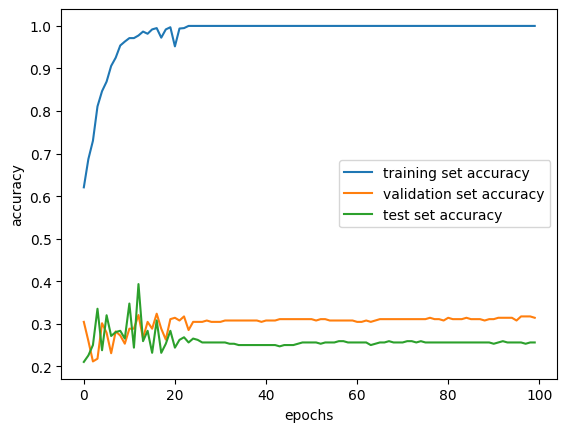

In [107]:
plt.plot([(val.cpu() / len(X_train) ) for val in train_correct], label='training set accuracy')
plt.plot([(val.cpu()/len(X_val) ) for val in val_correct], label='validation set accuracy')
plt.plot([(val.cpu()/len(X_test) ) for val in test_correct], label='test set accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')

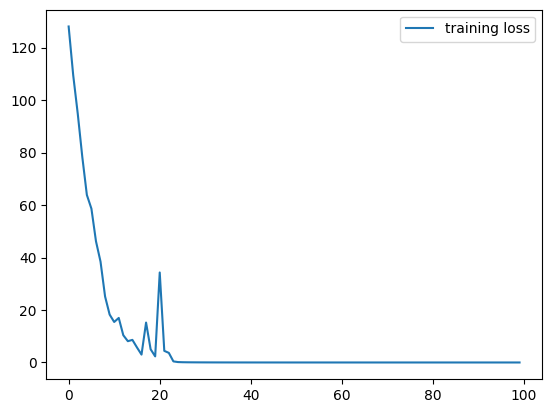

In [108]:
plt.plot([val.detach().cpu().numpy() for val in train_losses], label='training loss')

plt.legend()